## Importing Libraries

In [27]:
import os
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics 
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# Convert 'class' column to categorical
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


from collections import defaultdict

TensoFlow Version:  2.13.0-rc0


## Reading Data of Class Labels

In [2]:
# Define absolute path to your data
absolute_path = '/Users/diegogaray/Documents/Github/cpe429_project/ml_project/data/shorter_input/'

# Read label information
lab = pd.read_csv(os.path.join(absolute_path, 'frameAnnotations.csv'))


## Visualizing countplot of the classes

{'stop': 664, 'speedLimit35': 189, 'laneEnds': 173, 'speedLimit': 308, 'pedestrianCrossing': 725, 'keepRight': 140, 'yield': 40, 'signalAhead': 317, 'roundabout': 35, 'schoolSpeedLimit25': 19, 'turnRight': 44, 'schoolSpeedLimit': 30, 'zoneAhead45': 7, 'curveRight': 40, 'speedLimit25': 102, 'school': 34, 'noLeftTurn': 24, 'speedLimit30': 89, 'merge': 145, 'stopAhead': 68, 'addedLane': 178, 'truckSpeedLimit55': 18, 'speedLimit65': 27, 'zoneAhead25': 21, 'speedLimit45': 43, 'curveLeft': 18, 'truckSpeedLimit': 19, 'dip': 32, 'yieldAhead': 36, 'slow': 14, 'noUTurn': 19, 'rightLaneMustTurn': 33, 'leftTurn': 22, 'rampSpeedAdvisory': 19, 'thruMergeLeft': 24, 'doNotEnter': 4, 'rampSpeedAdvisory20': 9, 'turnLeft': 6, 'rampSpeedAdvisory35': 5, 'noRightTurn': 14, 'thruMergeRight': 7}
There have been a total of 3761 images identified


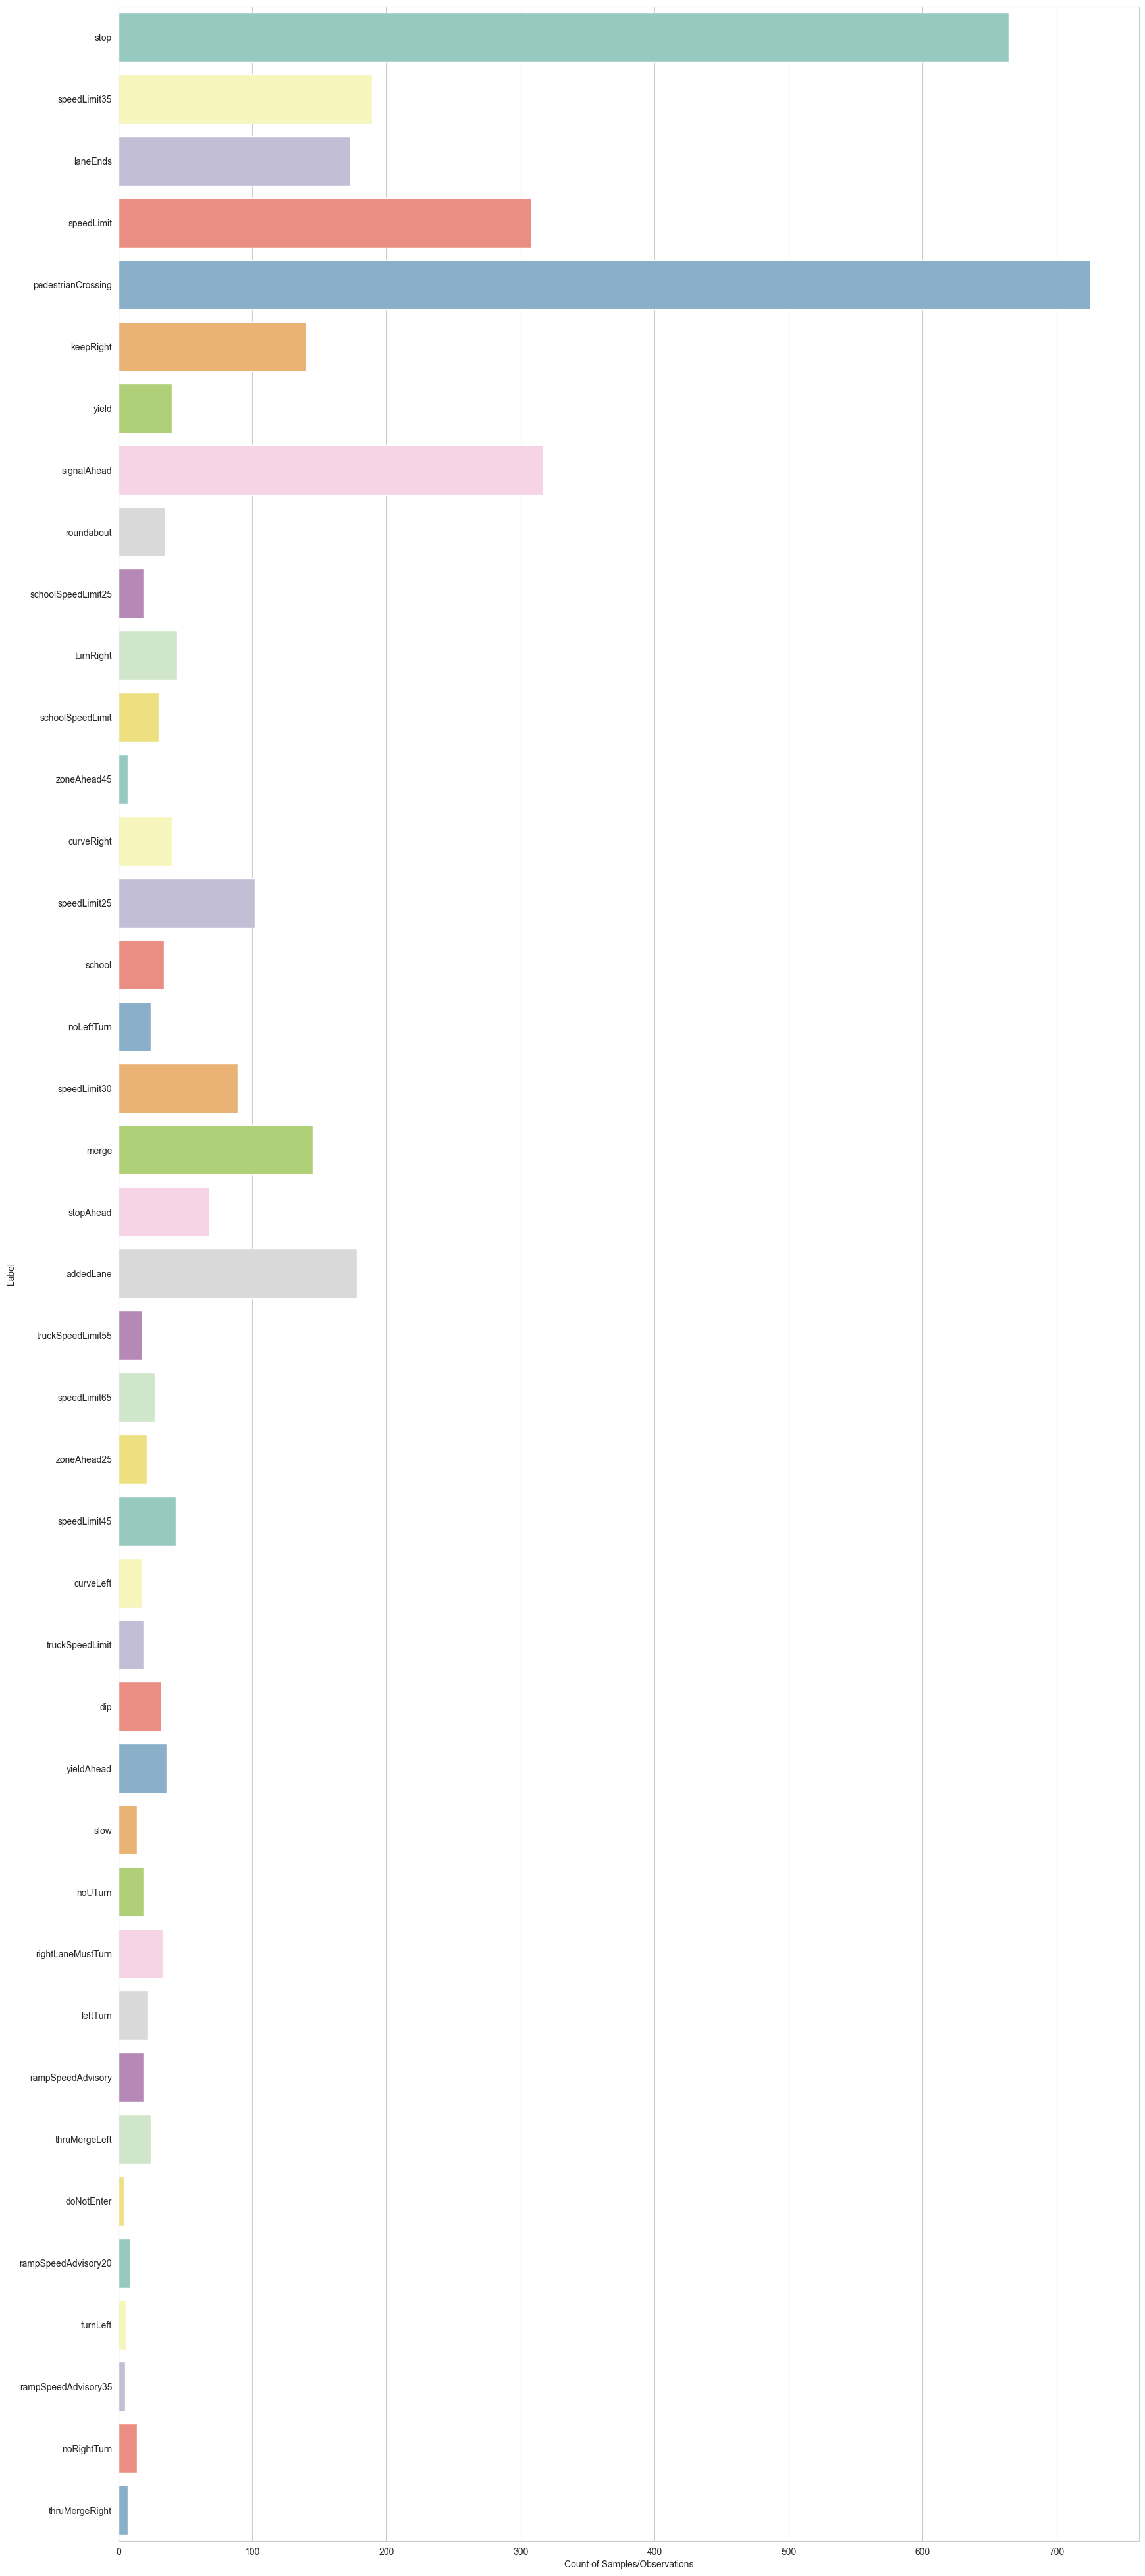

In [3]:
# Initialize a defaultdict to hold the counts. A defaultdict is used so that
# keys that are not currently in the dictionary default to a value of 0.
counts = defaultdict(int)

path = '/Users/diegogaray/Documents/Github/cpe429_project/ml_project/data/shorter_input/'

# Iterate over the files in the directory
for filename in os.listdir(path):
    # Check if the file is an image (ends with .png)
    if filename.endswith('.png'):
        # The class label is the part of the filename before the first underscore
        class_label = filename.split('_')[0]
        # Increment the count for this class label
        counts[class_label] += 1

# Convert the counts to a regular dictionary and print it
d = dict(counts)
print(d)

total = 0
for value in d.values():
    total += value

print(f"There have been a total of {total} images identified")
    

# Create the plot
plt.figure(figsize=(20, 50))
sns.barplot(y=list(d.keys()), x=list(d.values()), palette='Set3')
plt.ylabel('Label')
plt.xlabel('Count of Samples/Observations')
plt.show()


## Reading Image Data

In [4]:
# Initialize list to hold the data
data = []

# Iterate over the files in the directory
for filename in os.listdir(path):
    # Check if the file is an image (ends with .png)
    if filename.endswith('.png'):
        # The class label is the part of the filename before the first underscore
        class_label = filename.split('_')[0]
        # Append the filename and class label to the data
        data.append([filename, class_label])

# Convert the data to a DataFrame
df = pd.DataFrame(data, columns=['filename', 'class'])

# nb_classes = df['class'].nunique()

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=path,
    x_col="filename",
    y_col="class",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(32,32))

valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=path,
    x_col="filename",
    y_col="class",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(32,32))

Found 2821 validated image filenames belonging to 41 classes.
Found 940 validated image filenames belonging to 41 classes.


In [5]:
X, y = train_generator.next()
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(32, 32, 32, 3)
Labels shape :(32, 41)


## Sample Images of Dataset

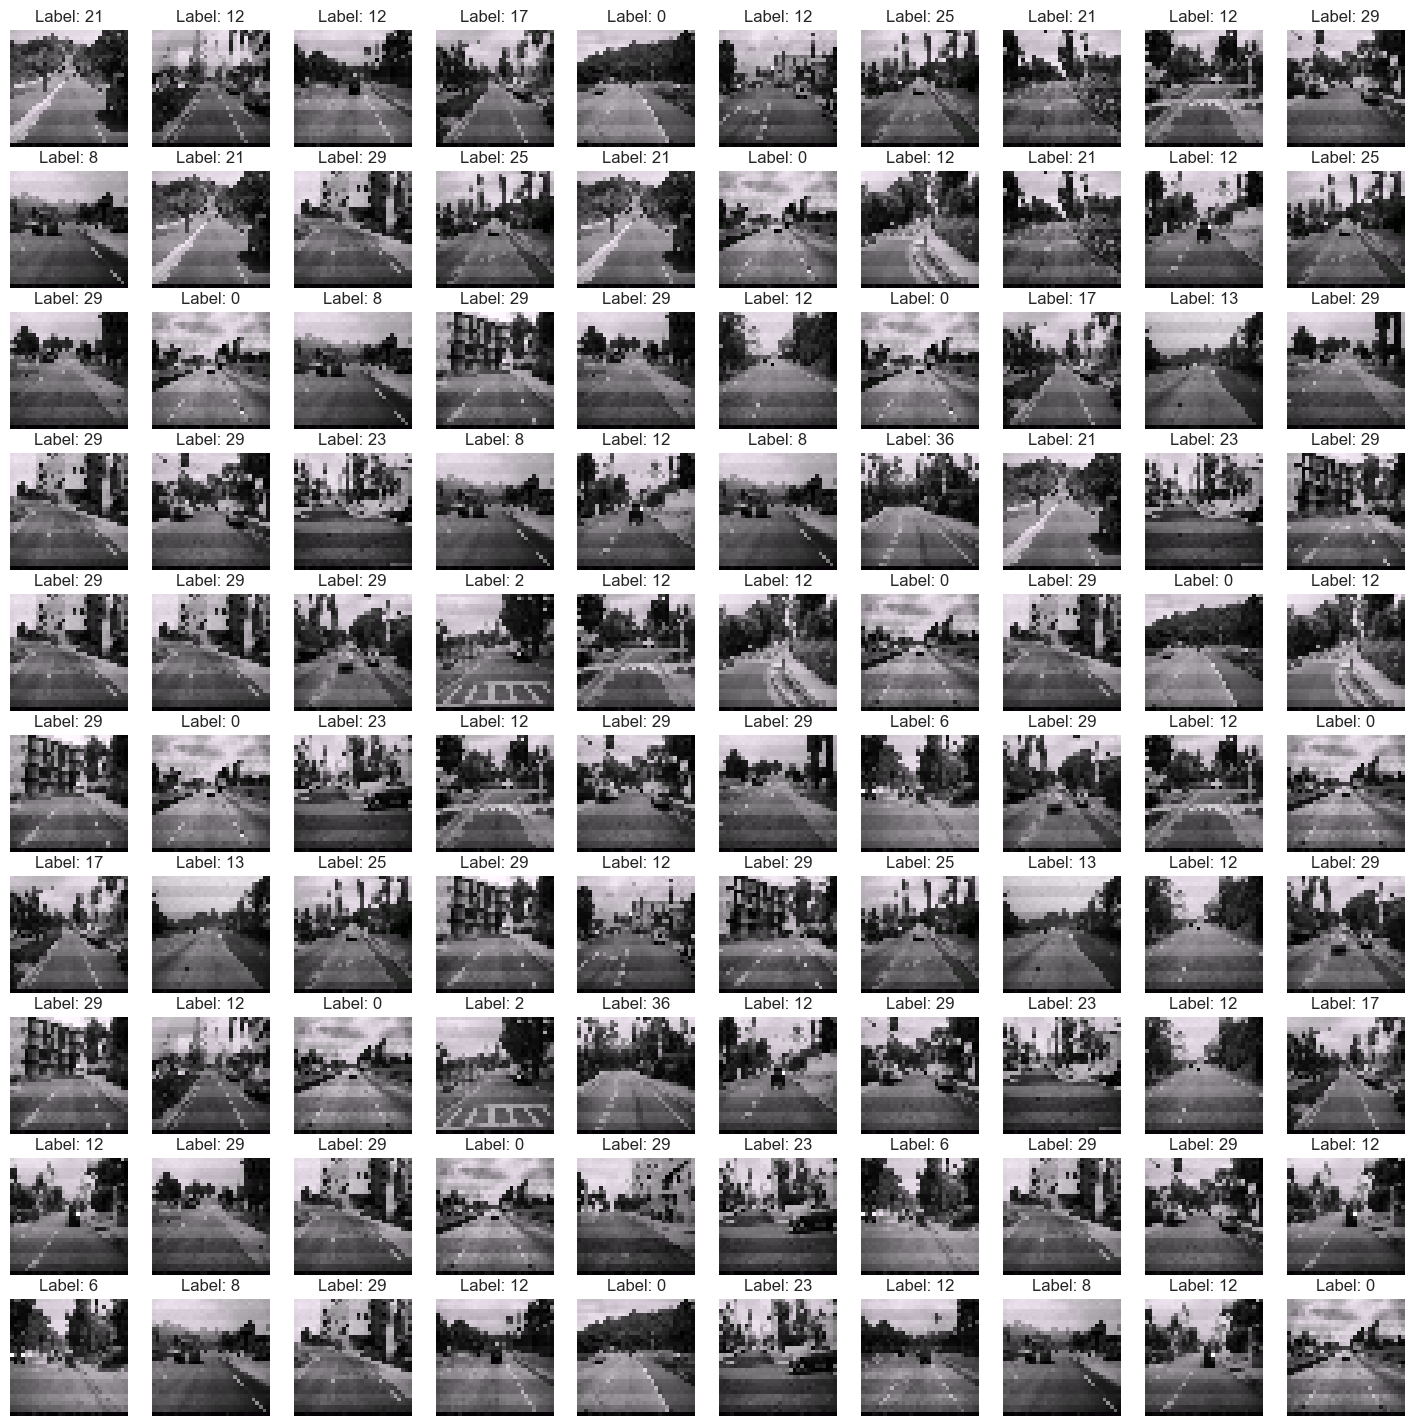

In [6]:

# Get one batch of images and their corresponding labels
X_batch, y_batch = next(train_generator)
fig, axes = plt.subplots(10, 10, figsize=(18, 18))

for i, ax in enumerate(axes.flat):
    # Draw a random image from the batch
    r = np.random.randint(X_batch.shape[0])
    image = X_batch[r]
    
    ax.imshow(image, interpolation='nearest')
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y_batch[r])))

plt.show()


## Dividing data into **train** and **test** in the split percentage of 80:20

In [28]:
'''
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)
X_train, X_test, y_train, y_test = train_test_split(df['filename'], df['class'], test_size=0.20, random_state=11)
'''

# encoding class values as integers
encoder = LabelEncoder()
encoder.fit(df['class'])
encoded_Y = encoder.transform(df['class'])
# convert integers to one hot encoded
Y = to_categorical(encoded_Y)

X_train, X_test, y_train, y_test = train_test_split(df['filename'], Y, test_size=0.20, random_state=11)



In [8]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (3008,)
Test Shape : (753,)


## Customising ResNet50 model  

In [9]:
img_rows = 32
img_cols = 32
img_channels = 3

resnet = ResNet50(weights= None, include_top=False, input_shape= (img_rows,img_cols,img_channels))

In [10]:
nb_classes = len(train_generator.class_indices)

In [11]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

## Visualising Model Architecture

In [13]:
plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Compiling the Model

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Creating Callbacks

In [15]:
model_check = ModelCheckpoint('model_checkpoint.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

# what stops the code from ending early
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=7, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')


## Fitting Model with Data

In [16]:
n_epochs = 25
#history = model.fit_generator(train_generator, epochs=n_epochs, validation_data=valid_generator, callbacks = [model_check, early, reduce_lr, csv_logger])
# Use model.fit instead of model.fit_generator
history = model.fit(train_generator, epochs=n_epochs, validation_data=valid_generator, callbacks = [model_check, early, reduce_lr, csv_logger])


Epoch 1/25


2023-05-31 14:25:42.648776: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


89/89 [==============================] - ETA: 0s - loss: 5.2332 - accuracy: 0.1691

2023-05-31 14:26:29.948452: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/Users/diegogaray/Documents/GitHub/cpe429_project/ml_project/test1/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


89/89 [==============================] - 62s 677ms/step - loss: 5.2332 - accuracy: 0.1691 - val_loss: 3.2517 - val_accuracy: 0.1926 - lr: 0.0010
Epoch 2/25
89/89 [==============================] - 59s 665ms/step - loss: 3.7937 - accuracy: 0.2421 - val_loss: 22.8495 - val_accuracy: 0.0787 - lr: 0.0010
Epoch 3/25
89/89 [==============================] - 59s 667ms/step - loss: 2.3650 - accuracy: 0.4566 - val_loss: 30.5430 - val_accuracy: 0.0266 - lr: 0.0010
Epoch 4/25
89/89 [==============================] - 60s 669ms/step - loss: 1.5270 - accuracy: 0.6147 - val_loss: 7.4363 - val_accuracy: 0.2011 - lr: 0.0010
Epoch 5/25
89/89 [==============================] - 59s 664ms/step - loss: 1.6570 - accuracy: 0.6030 - val_loss: 7.0060 - val_accuracy: 0.2340 - lr: 0.0010
Epoch 6/25
89/89 [==============================] - 59s 666ms/step - loss: 1.2466 - accuracy: 0.6803 - val_loss: 15.1115 - val_accuracy: 0.1734 - lr: 0.0010
Epoch 7/25
89/89 [==============================] - 59s 664ms/step - los

In [17]:
# Saving the model
model.save("saved_model.keras")

## Evaluate the Model

In [18]:
loss, acc = model.evaluate(valid_generator, steps=len(valid_generator))
print('Accuracy: ', acc, '\nLoss    : ', loss)

2023-05-31 14:50:27.417710: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


30/30 [==============================] - 14s 467ms/step - loss: 4.3523 - accuracy: 0.4287
Accuracy:  0.42872339487075806 
Loss    :  4.35228967666626


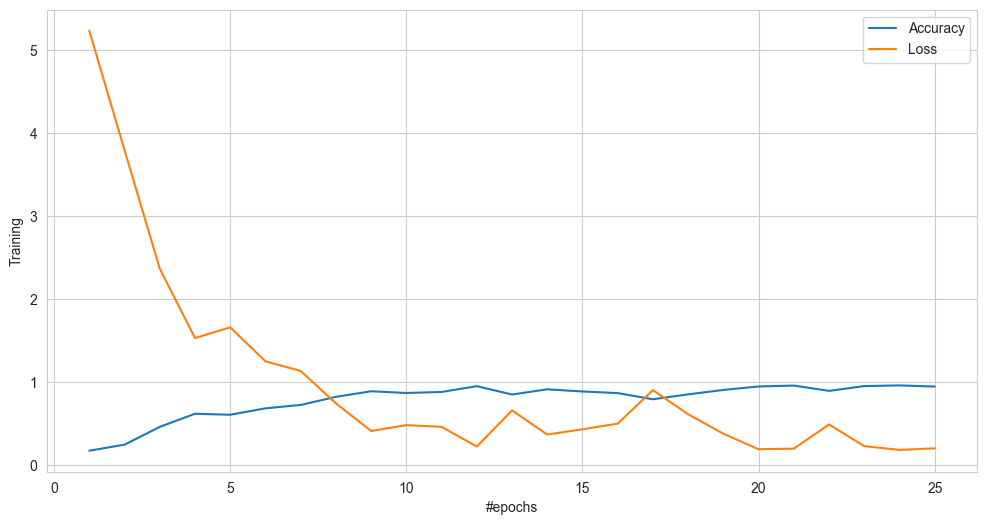

In [19]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();

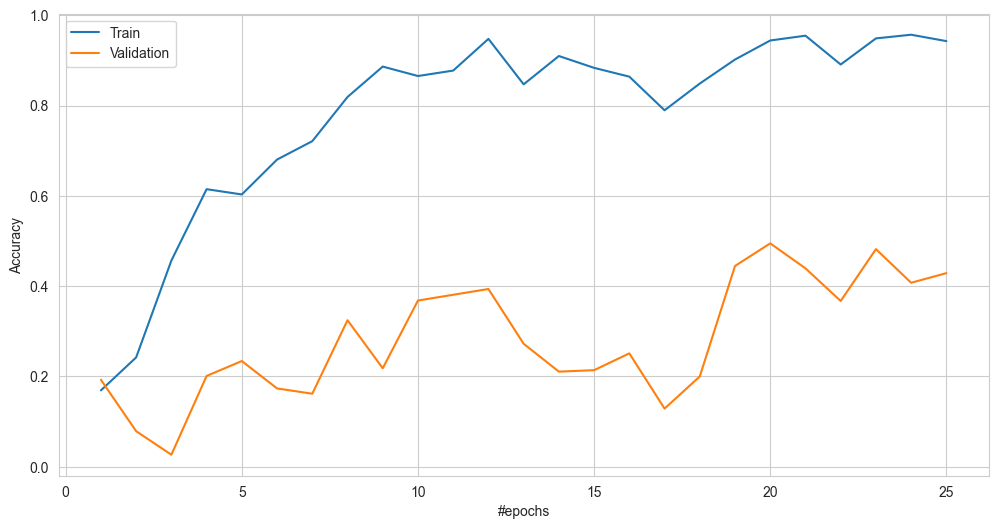

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend();

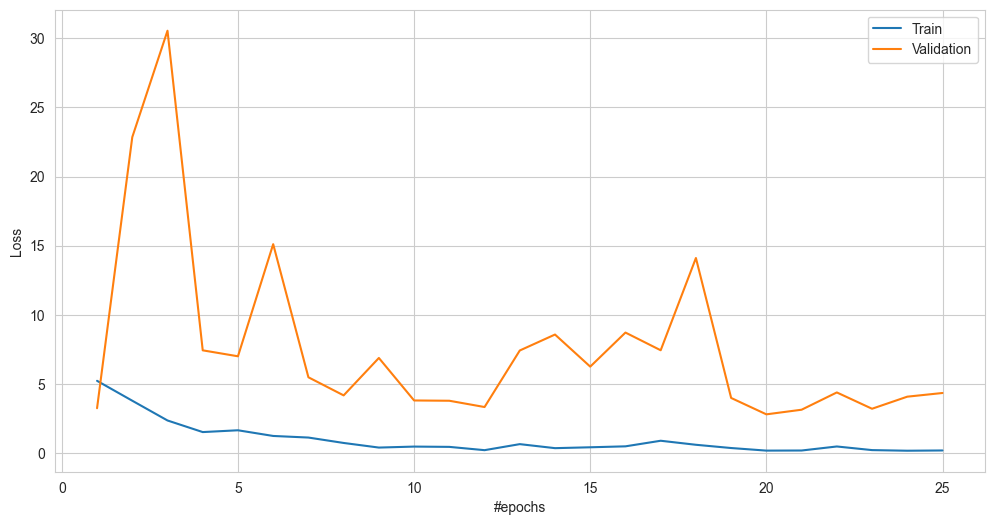

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend();

## Predict class labels of the test data

In [22]:
%%time

ValueError: in user code:

    File "/Users/diegogaray/Documents/GitHub/cpe429_project/ml_project/test1/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/Users/diegogaray/Documents/GitHub/cpe429_project/ml_project/test1/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/diegogaray/Documents/GitHub/cpe429_project/ml_project/test1/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/diegogaray/Documents/GitHub/cpe429_project/ml_project/test1/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/Users/diegogaray/Documents/GitHub/cpe429_project/ml_project/test1/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/diegogaray/Documents/GitHub/cpe429_project/ml_project/test1/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model' (type Functional).
    
    Input 0 of layer "conv1_pad" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 1)
    
    Call arguments received by layer 'model' (type Functional):
      • inputs=tf.Tensor(shape=(None, 1), dtype=string)
      • training=False
      • mask=None


In [23]:
# pred = np.argmax(model.predict(X_test), axis = 1)
# Define a function to load and preprocess an image
def load_and_preprocess_image(filename):
    img = tf.keras.preprocessing.image.load_img(os.path.join(path, filename), target_size=(32, 32)) 
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Rescale pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


In [24]:
# Load and preprocess the images in X_test
X_test_images = np.concatenate([load_and_preprocess_image(filename) for filename in X_test])

# Now predict the labels
pred = np.argmax(model.predict(X_test_images), axis=1)

24/24 [==============================] - 1s 33ms/step


## Classification Report

In [25]:
class_labels = train_generator.class_indices
labels = [k for k, v in sorted(class_labels.items(), key=lambda item: item[1])]


## Confusion Matrix

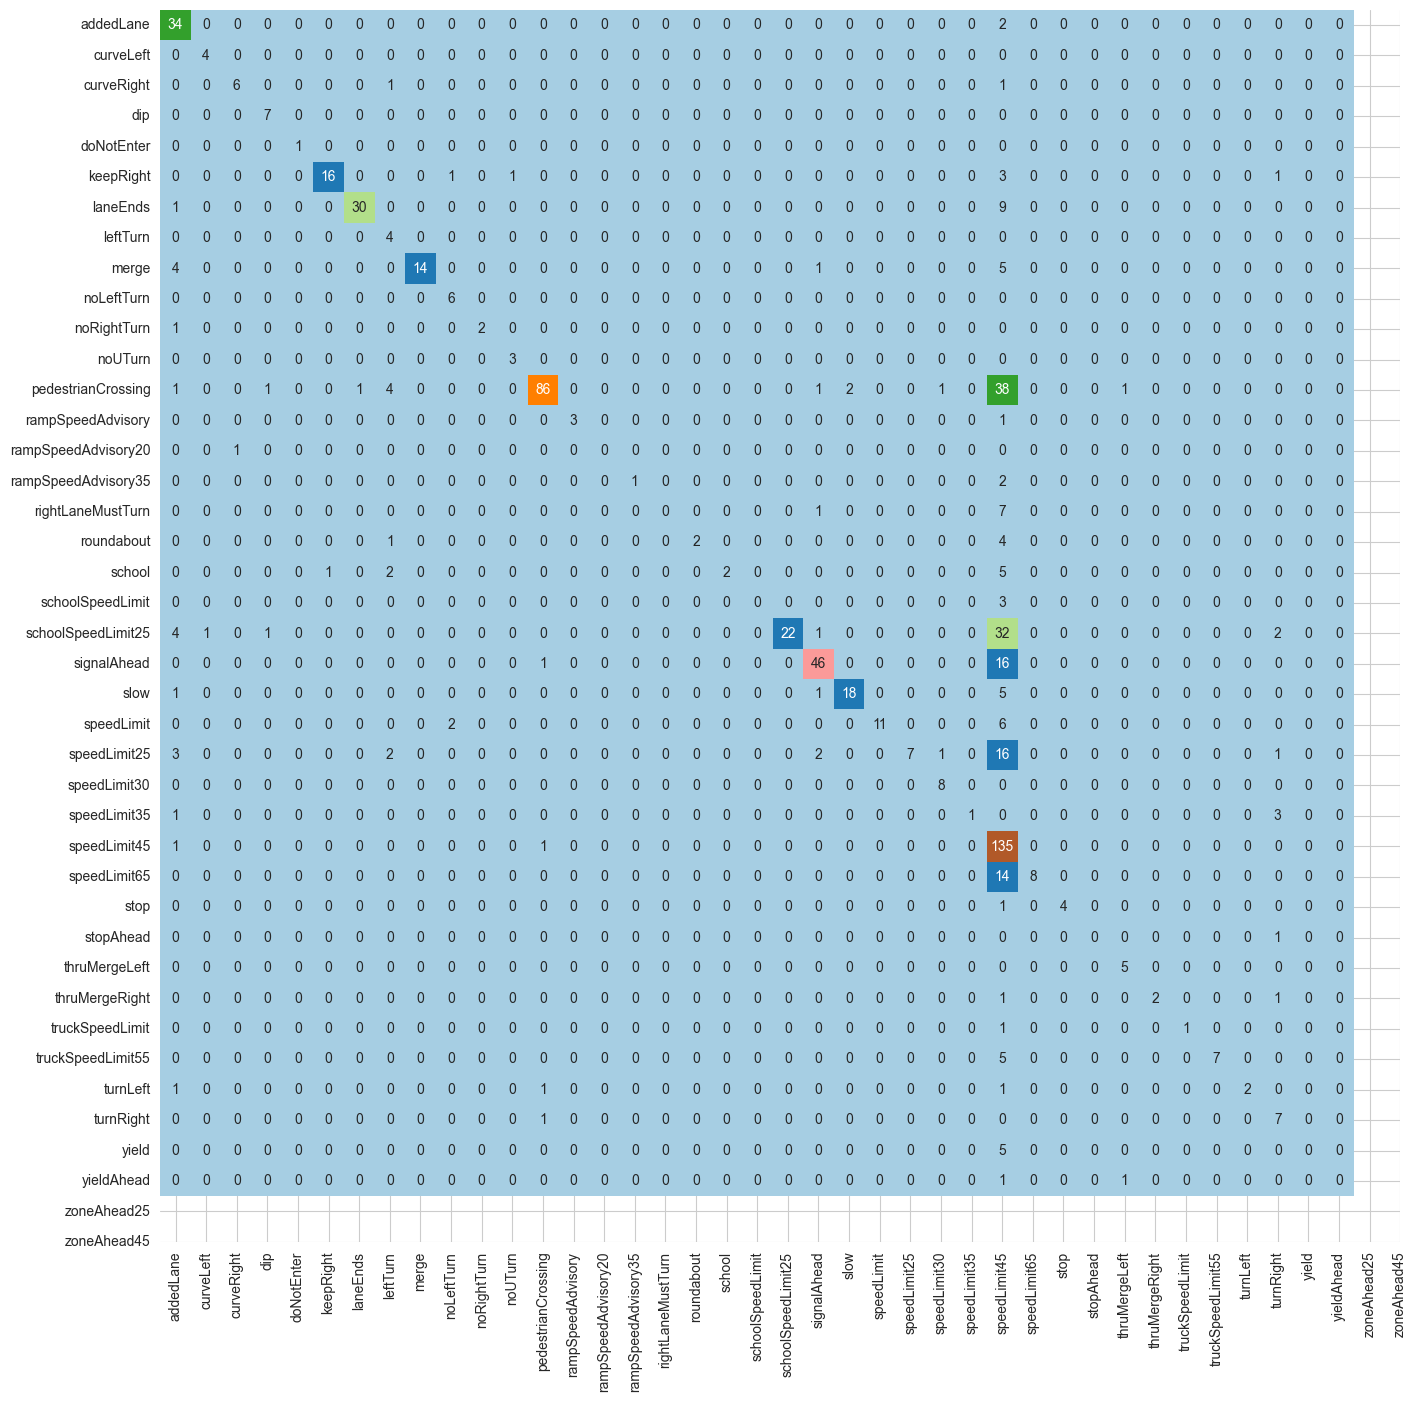

In [29]:
cmat = confusion_matrix(np.argmax(y_test, axis=1), pred)
plt.figure(figsize=(16,16))
sns.heatmap(cmat, annot = True, cbar = False, cmap='Paired', fmt="d", xticklabels=labels, yticklabels=labels);

## Classwise Accuracy

In [30]:
classwise_acc = cmat.diagonal() / cmat.sum(axis=1) * 100
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}

# create a dictionary with class labels as keys and accuracies as values
accuracy_dict = {class_labels[i]: acc for i, acc in enumerate(classwise_acc)}

# Now create a DataFrame, using a default accuracy for classes not in `accuracy_dict`
cls_acc = pd.DataFrame(
    {
        'Class_Label': sorted(class_labels.values()),  # Sort the class labels
        'Accuracy': [accuracy_dict.get(label, np.nan) for label in sorted(class_labels.values())]
    },
    columns=['Class_Label', 'Accuracy']
)

# Hide the index
cls_acc_styled = cls_acc.style.set_table_styles([{'selector': 'th.row_heading', 'props': [('display', 'none')]}])

# Apply formatting and create the bar chart
cls_acc_styled.format({"Accuracy": "{:,.2f}"}).bar(subset=["Accuracy"], color='tomato')

# Display the styled DataFrame
cls_acc_styled


,Class_Label,Accuracy
0,addedLane,94.44
1,curveLeft,100.00
2,curveRight,75.00
3,dip,100.00
4,doNotEnter,100.00
5,keepRight,72.73
6,laneEnds,75.00
7,leftTurn,100.00
8,merge,58.33
9,noLeftTurn,100.00


In [34]:
type(X_test)

pandas.core.series.Series

## Finally, Lets see the predictions of **unseen data**

1/1 [==============================] - 0s 17ms/step


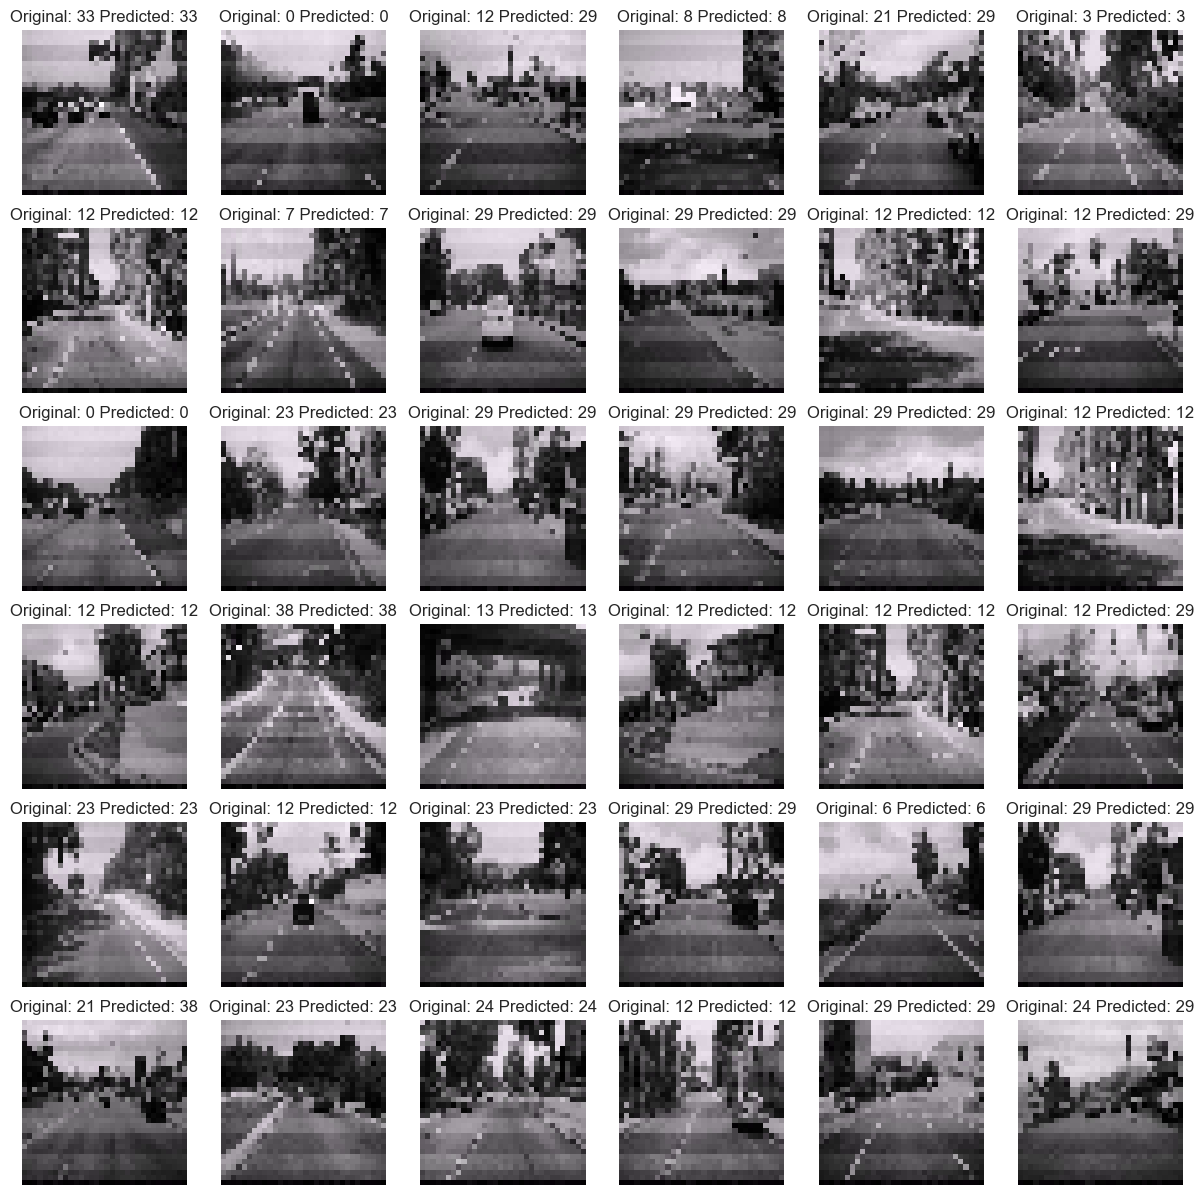

In [41]:
# Finally, Lets see the predictions of **unseen data**
fig, axes = plt.subplots(6, 6, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    filename = X_test.iloc[r]
    image = load_and_preprocess_image(filename)  # Load and preprocess the image
    label_true = np.argmax(y_test[r])
    label_pred = np.argmax(model.predict(image))
    
    # Convert the image back to the original scale (from [0, 1] to [0, 255])
    image = (image[0] * 255).astype('uint8')  # Index into the batch dimension to get the actual image
    
    ax.imshow(image)
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(label_true, label_pred))

plt.show()


--- 